# Empirical size-mass relation

There is an empirical size--stellar-mass relation in Misgeld & Hilker 2011 MNRAS 414, 3699 (doi:10.1111/j.1365-2966.2011.18669.x), and they provide a table of their input data. So let's try fitting a curve to the ridge-line for the dwarfs $M^* < 10^9$ and look at the scatter in $\log(Re)$ about that to see if that looks sensible.

In [39]:
import numpy as np
from scipy import stats
from scipy import integrate
from scipy import interpolate
from astropy.table import Table
from scipy.stats import rv_continuous
from astropy.stats import sigma_clip,mad_std
from astropy.modeling import models, fitting
from scipy import stats

In [134]:
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [6]:
misgeld=Table.read('data/mnras0414-3699-SD1.txt',format='ascii.commented_header')
misgeld[:5]

name,ref,Mv,logRe,logM*,logSigma_e
str11,int64,float64,float64,float64,float64
N0315,1,-24.6,4.486,12.432,2.662
N0584,1,-22.6,3.724,11.535,3.289
N0636,1,-21.6,3.562,11.088,3.166
N0720,1,-22.6,3.84,11.608,3.13
N0777,1,-23.6,4.134,12.012,2.946


Looking at the paper, we can choose just a few subsets of the references to get the E and dE galaxies. 

(1, 5)

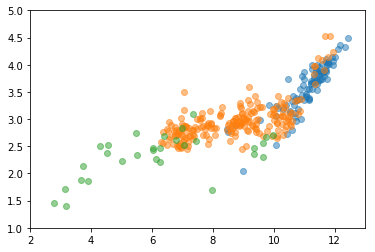

In [7]:
EdE=(misgeld['ref']==2) | (misgeld['ref']==3)
dsph = misgeld['ref']==11
bender=misgeld['ref']==1
plt.scatter(misgeld['logM*'][bender],misgeld['logRe'][bender],alpha=0.5)
plt.scatter(misgeld['logM*'][EdE],misgeld['logRe'][EdE],alpha=0.5)
plt.scatter(misgeld['logM*'][dsph],misgeld['logRe'][dsph],alpha=0.5)
plt.xlim(2,13)
plt.ylim(1,5)

Let's select just the sample of E and dE galaxies with masses $4 < \log M^* < 9$. 

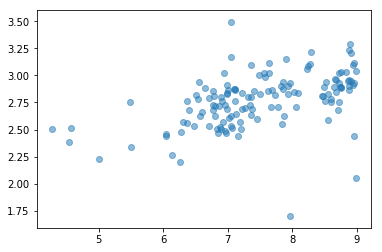

In [16]:
sample = ((EdE) | (dsph) | (bender)) & (misgeld['logM*']<9) & (misgeld['logM*']>4)
plt.scatter(misgeld['logM*'][sample],misgeld['logRe'][sample],alpha=0.5)
#plt.xlim(2,13)
#plt.ylim(1,5)

This looks mostly linear with a few outliers, so let's fit a line with rejection

In [20]:
x = misgeld['logM*'][sample]
y = misgeld['logRe'][sample]

In [27]:
p = models.Polynomial1D(1)
fit = fitting.LinearLSQFitter()
or_fit  = fitting.FittingWithOutlierRemoval(fit, sigma_clip,
                                           niter=3, sigma=3.0)
result,mask = or_fit(p,x,y)
result

<Polynomial1D(1, c0=1.74038461, c1=0.13943115)>

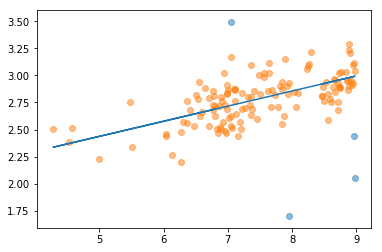

In [29]:
plt.scatter(x[mask],y[mask],alpha=0.5)
plt.scatter(x[~mask],y[~mask],alpha=0.5)
plt.plot(x,result(x))

Estimate the width of the residuals around the best-fit line and compare to a Gaussian. And to a t distribution with 5 degrees of freedom to give it somewhat heavier tails. 

0.16816495175239551


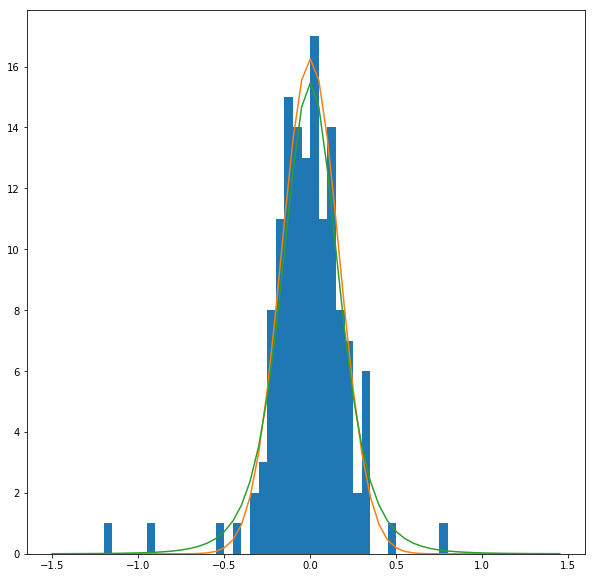

In [140]:
resid = y-result(x)
foo = plt.hist(resid,np.arange(-1.5,1.5,0.05))
sigma = mad_std(resid[~mask]) # Estimate a robust standard deviation
xx=np.arange(-1.5,1.5,0.05)
plt.plot(xx,len(x)*stats.norm(loc=0,scale=sigma).pdf(xx)*0.05)
plt.plot(xx,len(x)*stats.t(loc=0,scale=sigma,df=5).pdf(xx)*0.05)
print(sigma)

In [141]:
class size_picker:
    def __init__(self):
        self.c0 = 1.74038461
        self.c1 = 0.13943115
        self.sigma = 0.17
        self.scatter = stats.t(loc=0,scale=sigma,df=5)
    def size(self,logmass):
        return self.c1*logmass+self.c0 + self.scatter.rvs(len(logmass))

Plot a few realizations and compare to the data

(1.5, 4)

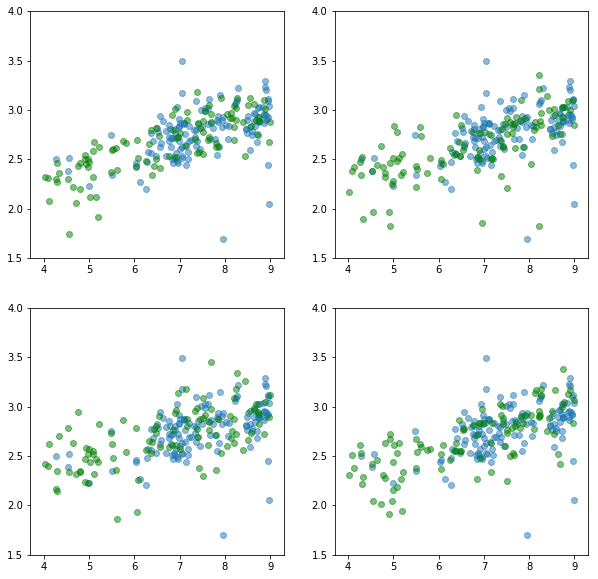

In [142]:
sp = size_picker()
masses = np.random.uniform(4,9,size=100)
plt.subplot(221)
plt.scatter(x,y,alpha=0.5)
plt.scatter(masses,sp.size(masses),color='g',alpha=0.5)
plt.ylim(1.5,4)
plt.subplot(222)
plt.scatter(x,y,alpha=0.5)
plt.scatter(masses,sp.size(masses),color='g',alpha=0.5)
plt.ylim(1.5,4)
plt.subplot(223)
plt.scatter(x,y,alpha=0.5)
plt.scatter(masses,sp.size(masses),color='g',alpha=0.5)
plt.ylim(1.5,4)
plt.subplot(224)
plt.scatter(x,y,alpha=0.5)
plt.scatter(masses,sp.size(masses),color='g',alpha=0.5)
plt.ylim(1.5,4)